In [12]:
import tensorflow as tf
import sys
from tensorflow import keras
from tensorflow.keras import backend as kb
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Flatten, Conv2D
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

In [55]:
def findAvgs(numberOfClasses, model):    
    Avgs = []
    Stds = []
    for idx in range(numberOfClasses):
        predictions = np.empty([1, model.numFeatures])
        #print(predictions.shape)
        for input_ in buffer[idx]:
            tmp = np.expand_dims(np.array(input_), axis=0) 
            
            #prediction = tf.squeeze(model(tmp)).numpy()
            prediction = model(tmp).numpy()
            
            predictions = np.concatenate((predictions, prediction), axis=0)
        predictions = np.delete(predictions, 0, axis=0)
        avg = np.average(predictions, axis=0)
        std = np.std(predictions, axis=0)
        Avgs.append(avg)
        Stds.append(std)
    return Avgs, Stds

def Acc(Avgs, model):
    total = 0
    positive = 0
    accs = []
    for idx in range(numberOfClasses):
        total_sub = 0
        positive_sub = 0
        for input_ in buffer[idx]:
            total_sub += 1
            
            tmp = np.expand_dims(np.array(input_), axis=0) 
            prediction = tf.squeeze(model(tmp)).numpy()
            
            answer = None
            distance_min = np.inf
            for i, avg in enumerate(Avgs):
                distance = np.linalg.norm(prediction - avg)
                if( distance < distance_min):
                    distance_min = distance
                    answer = i
            if answer == idx:
                positive_sub += 1
        
        accs.append(positive_sub * 100 / total_sub)
        total += total_sub
        positive += positive_sub
    return positive * 100.0 / total, accs

In [14]:
def separateFairly(batchSize, numClasses):
    
    ratio = []
    for i in range(numClasses):
        ratio.append(batchSize//numClasses)
    
    choice = np.random.choice(numClasses, batchSize - sum(ratio), replace=False)
    
    for idx in choice:
        ratio[idx] += 1
    
    return ratio

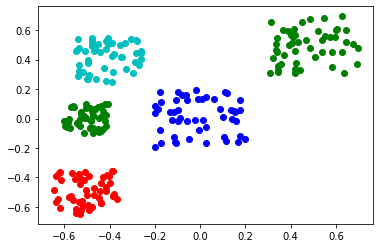

In [15]:
def DataGenerator(center, length, numberOfdata):
    
    buffer = {}
    fig = plt.figure()
    for i in range(len(center)):
        tmp = tf.random.uniform([numberOfdata, 2], maxval = length[i])
        a = tf.constant([[center[i][0] - length[i]/2.0, center[i][1] - length[i]/2.0]])
        inputs_ = tf.add(tmp, a)
        
        if answer[i] in buffer.keys():
            buffer[answer[i]] = tf.concat([buffer[answer[i]], inputs_], axis=0)
            
        else:
            buffer[answer[i]] = inputs_
        
        for elem in inputs_:
            plt.scatter(elem[0], elem[1], c=colors[answer[i]])
        
        #print(inputs_.shape)
        #print(a)
    return buffer

numberOfClasses = 4

colors = ['r', 'g', 'b', 'c', 'm']
answer = [0, 1, 2, 1, 3]

centerPoint = [[-0.5, -0.5], [0.5, 0.5], [0, 0], [-0.5, 0], [-0.4, 0.4]]
length = [0.3, 0.4, 0.4, 0.2, 0.3]
numOfPoint_total = 50

buffer = DataGenerator(centerPoint, length, numOfPoint_total)


######################################################################
numberOfClasses = 4
batchsize = 32
numberOfBatches = 1000

ratio = separateFairly(batchsize, numberOfClasses)

inputs = np.empty([1, batchsize, 2])
outputs = np.empty([1, batchsize])

for i in range(numberOfBatches):
    
    input_ = np.empty([1, 2])
    output_ = np.empty([1])
    
    for idx in range(numberOfClasses):  
        choice_idx = np.random.choice(buffer[idx].shape[0], ratio[idx], replace=False)
        #print(buffer[idx].shape)
        chosen = tf.gather(buffer[idx], choice_idx)#.numpy()
        #print(chosen.shape)
        input_ = np.concatenate((input_, chosen), axis=0)
        
        tmp = np.empty(ratio[idx])
        tmp.fill(idx)
        output_ = np.concatenate((output_, tmp))
        
    input_ = np.delete(input_, 0, axis=0)
    output_ = np.delete(output_, 0, axis=0)
    
    input_ = np.expand_dims(input_, axis=0)
    output_ = np.expand_dims(output_, axis=0)
    
    inputs = np.concatenate((inputs, input_), axis=0)
    outputs = np.concatenate((outputs, output_), axis=0)
    
    #break
    
inputs = np.delete(inputs, 0, axis=0)
outputs = np.delete(outputs, 0, axis=0)

dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs)).shuffle(inputs.shape[0], reshuffle_each_iteration=True)
trainDataset = dataset.take(int(numberOfBatches * 0.7))
validDataset = dataset.skip(int(numberOfBatches * 0.7))

In [16]:
class distanceLoss(keras.losses.Loss):
    def __init__(self, name="distanceLoss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        avgs = None
        
        for i in range(numberOfClasses):
            idx = tf.squeeze(tf.where(tf.equal(y_true, i)))
            tmp = tf.gather(y_pred, idx)
            avg = tf.reduce_mean(tmp, 0)
            
            if avgs is None:
                avgs = tf.expand_dims(avg, 0)
            else:
                avgs = tf.concat([avgs, tf.expand_dims(avg, 0)], 0)
                
        distance = tf.math.reduce_std(avgs, 0)
        #L1 = 1 / tf.norm(tmp)
        
        Loss = 1 / (tf.norm(distance) + kb.epsilon())
        #tf.print(L1, output_stream=sys.stderr)
        return Loss

    
class stdLoss(keras.losses.Loss):
    def __init__(self, name="stdLoss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        stds = None
        
        for i in range(numberOfClasses):
            idx = tf.squeeze(tf.where(tf.equal(y_true, i)))
            tmp = tf.gather(y_pred, idx)
            std = tf.math.reduce_std(tmp, 0)
            
            if stds is None:
                stds = tf.expand_dims(std, 0)
            else:
                stds = tf.concat([stds, tf.expand_dims(std, 0)], 0)
                
        #tf.print(stds, output_stream=sys.stderr)
        
        tmp = tf.norm(stds, axis=1)
        #tf.print(tmp, output_stream=sys.stderr)
        Loss =  tf.math.reduce_sum(tmp)
        #tf.print(L2, output_stream=sys.stderr)
        
        return Loss

In [74]:
class MyModel(Model):
    def __init__(self, numFeatures=3):
        super(MyModel, self).__init__()
        self.numFeatures = numFeatures
        self.idxFeatures = []
        self.custom_layers = self.initializer()
        
    def initializer(self):
        for idx in range(self.numFeatures):
            self.idxFeatures.append([0, idx])
        return [Dense(self.numFeatures)]
    
    def addLayer(self, numNodes):
        weights = self.custom_layers[-1].get_weights()
        numPreNodes = weights[0].shape[1]
        tmp = np.zeros((1, numPreNodes))
        
        self.custom_layers.append(Dense(numNodes))
        self.custom_layers[-1](tmp)
        
        self.idxFeatures = []
        self.numFeatures = numNodes
        for i in range(self.numFeatures):
            self.idxFeatures.append([len(self.custom_layers) - 1, i])
        
    def addNode(self, idx_layer):
        weights = self.custom_layers[idx_layer].get_weights()
        
        inputDims = weights[0].shape[0]
        numNodes = weights[0].shape[1]
        
        tmp = np.random.normal(size=(inputDims, 1))
        weights[0] = np.concatenate((weights[0], tmp), axis=1)
        
        tmp = np.random.normal((1,))
        weights[1] = np.concatenate((weights[1], tmp))
        
        self.custom_layers[idx_layer] = Dense(numNodes + 1)
        tmp = np.zeros((1, inputDims))
        self.custom_layers[idx_layer](tmp)
        self.custom_layers[idx_layer].set_weights(weights)
        
    def setIdx(self, feature, idx):
        self.idxFeatures[feature] = idx
        
    def addFeature(self, idx):
        self.idxFeatures.append(idx)
        self.numFeatures += 1

    def call(self, x):
        outputs = {}
        result = tf.zeros([x.shape[0], 1])
        for idx_layer, layer_ in enumerate(self.custom_layers):
            x = tf.math.sin(layer_(x)) 
            for feature, feature_idx in enumerate(self.idxFeatures):
                if idx_layer == feature_idx[0]:
                    outputs[feature] = tf.gather(x, feature_idx[1], axis=1)
                    
        for feature, value in outputs.items():
            #print(value)
            result = tf.concat([result, tf.expand_dims(outputs[0], axis=-1)], axis=1)
        result = result[:,1:]
        
        return result


model = MyModel(numFeatures=2)

for input_, output_ in trainDataset:
    model(input_)
    break
print(model.numFeatures)
print(model.idxFeatures)
model.summary()
"""
model.addLayer(2)
model.setIdx(0, [1,0])
model.setIdx(1, [1,1])
for input_, output_ in trainDataset:
    model(input_)
    break
print(model.numFeatures)
print(model.idxFeatures)
model.summary()
"""

2
ListWrapper([ListWrapper([0, 0]), ListWrapper([0, 1])])
Model: "my_model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             multiple                  6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


'\nmodel.addLayer(2)\nmodel.setIdx(0, [1,0])\nmodel.setIdx(1, [1,1])\nfor input_, output_ in trainDataset:\n    model(input_)\n    break\nprint(model.numFeatures)\nprint(model.idxFeatures)\nmodel.summary()\n'

In [76]:
L1 = distanceLoss()
L2 = stdLoss()

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
L1_train = tf.keras.metrics.Mean()
L2_train = tf.keras.metrics.Mean()  

@tf.function
def train_step(input_, output_):
    with tf.GradientTape() as tape:
        #print(input_.shape)
        
        predictions = model(input_)
        l1 = L1(output_, predictions)
        l2 = L2(output_, predictions)
        Loss = l1 #+ l2
        #Loss = L12(output_, predictions)
        
        
    
    gradients = tape.gradient(Loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    L1_train(l1)
    L2_train(l2)
    


L1_valid = tf.keras.metrics.Mean()
L2_valid = tf.keras.metrics.Mean()
@tf.function
def test_step(input_, output_):
    predictions = model(input_)
    
    l1 = L1(output_, predictions)
    l2 = L2(output_, predictions)# may vary

    L1_valid(l1)
    L2_valid(l2)

In [86]:
EPOCHS = 1000
patience = 100
stopped_epoch = 0
best_weights = None
best = np.Inf
wait = 0

model.addNode(2)
model.addFeature([2, 2])

#model.addLayer(2)
#model.setIdx(0, [2,0])
#model.setIdx(1, [2,1])
#model.setIdx(2, [2,1])

#model.addNode(2)

for input_, output_ in trainDataset:
    model(input_)
    break


for epoch in range(EPOCHS):
    clear_output(wait=True)
    
    print(model.numFeatures)
    print(model.idxFeatures)
    model.summary()

    for input_, output_ in trainDataset:
        train_step(input_, output_)
        #break
    #break
    for input_, output_ in validDataset:
        test_step(input_, output_)
    
    template = '에포크: {}, L1_train: {:.4f}, L2_train: {:.3f}, L1_valid: {:.4f}, L2_valid: {:.3f}'
    print (template.format(epoch+1,
                         L1_train.result(),
                         L2_train.result(),
                         L1_valid.result(),
                         L2_valid.result()))
    
    if np.less(float(L1_valid.result() + L2_valid.result()), best):
        best = float(L1_valid.result() + L2_valid.result())
        best_weights = model.get_weights()
        wait = 0
    else:
        wait +=1
        if wait >= patience:
            model.set_weights(best_weights)
            stopped_epoch = epoch
            print('Early Stopped !')
            break
#model.save_weights('last')
Avgs, Stds = findAvgs(numberOfClasses, model)
acc_total, accs = Acc(Avgs, model)

for i in range(numberOfClasses):
    print('class :', i, 'Acc : ', accs[i],'%',  ' Avg : ', np.round_(Avgs[i],4), ' Std : ', np.round_(Stds[i],4), ' |Std| : ', np.round_(np.linalg.norm(Stds[i])))
print('Acc_total : ', acc_total)

ValueError: Input 0 of layer dense_54 is incompatible with the layer: expected axis -1 of input shape to have value 4 but received input with shape (32, 5)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 2

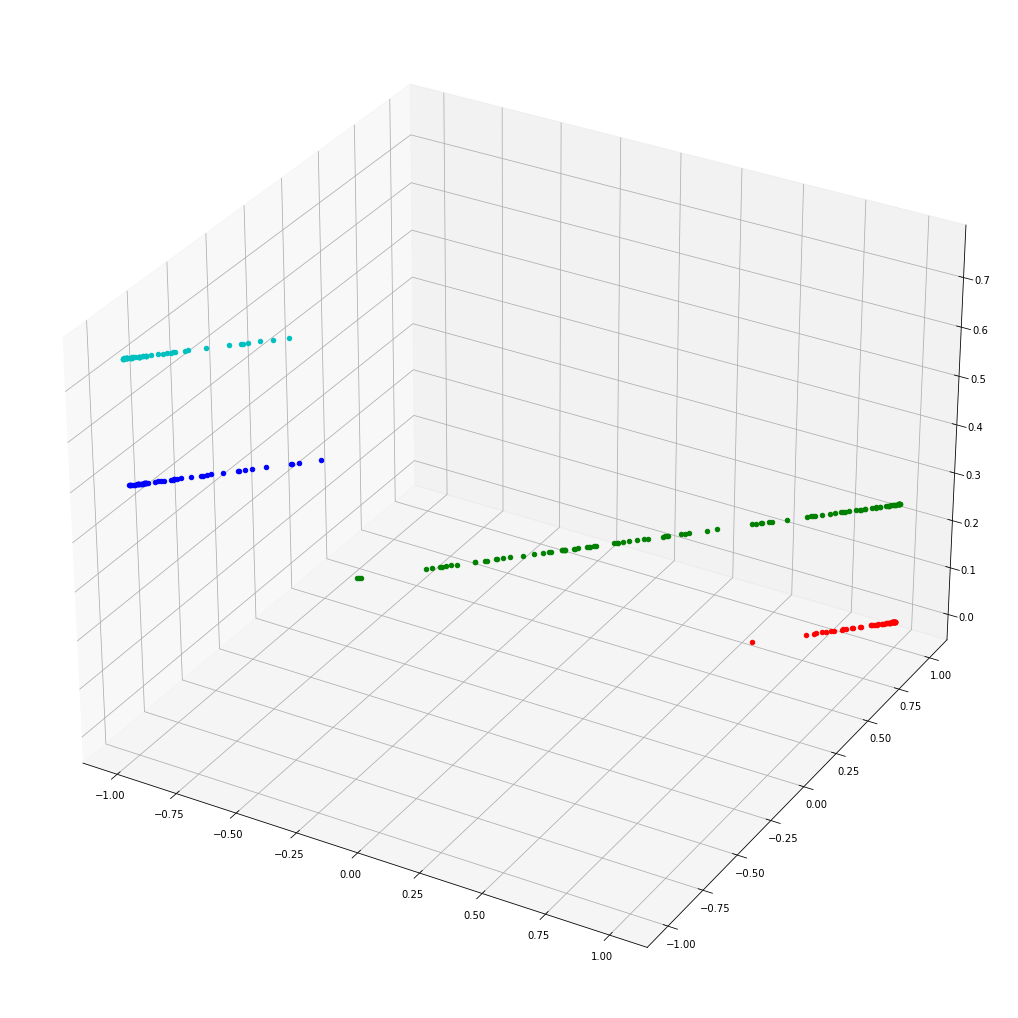

In [211]:
## 3차원        
fig= plt.figure(figsize=(18,20))
ax = fig.add_subplot(111, projection='3d')

for idx in range(numberOfClasses):
    if True:
        for input_ in buffer[idx]:

            tmp = np.expand_dims(np.array(input_), axis=0) 
            prediction = tf.squeeze(model(tmp)).numpy()
            #print(prediction.shape)

            ax.scatter(prediction[0], prediction[1], idx/numberOfClasses, c=colors[idx])
            #ax.scatter(prediction, idx / numberOfClasses, 0, c=colors[idx])

            #print(prediction)

In [187]:
model.addLayer(3)
model.summary()

Model: "my_model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             multiple                  15        
_________________________________________________________________
dense_65 (Dense)             multiple                  30        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
